<a href="https://colab.research.google.com/github/gautam-pai/PyTorch-Learning/blob/main/Convolutional_Neural_Network_Working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
## Convert MNIST image files into tensor 4 dimensions(# of images, height, width, color channel)

transform=transforms.ToTensor()

In [7]:
## TRain data
train_data=datasets.MNIST(root='/cnn_data',train=True,download=True,transform=transform)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]


Extracting /cnn_data/MNIST/raw/train-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 488kB/s]


Extracting /cnn_data/MNIST/raw/train-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.38MB/s]


Extracting /cnn_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.99MB/s]

Extracting /cnn_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



In [8]:
## Test Data

test_data=datasets.MNIST(root='/cnn_data',train=False,download=True,transform=transform)

In [9]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [10]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [11]:
## Creating a small batch size of 10
train_loader=DataLoader(train_data,batch_size=10,shuffle=True)
test_loader=DataLoader(test_data,batch_size=10, shuffle=False)

In [12]:
# Defining a CNN model
 # 2 Convolutional layers
 # Here the first in_Channel means, we're taking one image as input, and getting 6 outputs
 # In the sencond conv, we're giving the first conv's 6 output as input and expecting 16 output( this 16 is arbitrary, as per our wish)
conv1=nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3,stride=1)
conv2=nn.Conv2d(in_channels=6,out_channels=16,kernel_size=3,stride=1)


In [13]:
## Grab 1 MNIST image
for i,(X_Train,y_train) in enumerate(train_data):
  break

In [14]:
X_Train.shape


torch.Size([1, 28, 28])

In [15]:
x=X_Train.view(1,1,28,28)

In [16]:
## performing the 1st conv
x=F.relu(conv1(x))

In [17]:
x.shape

torch.Size([1, 6, 26, 26])

In [18]:
## pass through the pooling layer
x=F.max_pool2d(x,2,2)

In [19]:
x.shape

torch.Size([1, 6, 13, 13])

In [20]:
# 2nd conv layer
x=F.relu(conv2(x))

In [21]:
x.shape

torch.Size([1, 16, 11, 11])

In [22]:
## 2nd pooling layer

x=F.max_pool2d(x,2,2)

In [23]:
x.shape

torch.Size([1, 16, 5, 5])

In [24]:
## Complete model
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(1,6,3,1)
    self.conv2=nn.Conv2d(6,16,3,1)
    ## Fully connected layer
    self.fc1=nn.Linear(5*5*16,120)
    self.fc2=nn.Linear(120,84)
    self.fc3=nn.Linear(84,10)

  def forward(self,X):
    X=F.relu(self.conv1(X))
    X=F.max_pool2d(X,2,2)
    # Second Pass
    X=F.relu(self.conv2(X))
    X=F.max_pool2d(X,2,2)

    ## Flatten
    X=X.view(-1,16*5*5) # -1 so that we can vary the batch size
    # Fully connected layers
    X=F.relu(self.fc1(X))
    X=F.relu(self.fc2(X))
    X=self.fc3(X)

    return F.log_softmax(X,dim=1)



In [25]:
## Create an instance of model

torch.manual_seed(41)
model=CNN()


In [26]:
model

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [27]:
## Loss Function optimizer
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)


In [28]:
import time
start_time=time.time()
# create variables to track things-
epochs=5
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]

# for loop epochs
for i in range(epochs):
  trn_corr=0
  tst_corr=0


# train
  for b,(X_Train,y_train) in enumerate(train_loader):
    b+=1
    y_pred=model(X_Train)
    loss=criterion(y_pred,y_train)

    predicted=torch.max(y_pred.data,1)[1]
    batch_corr=(predicted==y_train).sum()
    trn_corr+=batch_corr
#update parameters

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

#print results
    if b%600==0:
      print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

# Test

  with torch.no_grad():
    for b,(X_test,y_test) in enumerate(test_loader):
      y_val=model(X_test)
      predicted=torch.max(y_val.data,1)[1]
      tst_corr+=(predicted==y_test).sum()
  loss=criterion(y_val,y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)


current_time=time.time()
total=current_time-start_time

Epoch: 0  Batch: 600  Loss: 0.1623610556125641
Epoch: 0  Batch: 1200  Loss: 0.1502392590045929
Epoch: 0  Batch: 1800  Loss: 0.4744560718536377
Epoch: 0  Batch: 2400  Loss: 0.14238706231117249
Epoch: 0  Batch: 3000  Loss: 0.007758188061416149
Epoch: 0  Batch: 3600  Loss: 0.3836284875869751
Epoch: 0  Batch: 4200  Loss: 0.0038223876617848873
Epoch: 0  Batch: 4800  Loss: 0.0021286322735249996
Epoch: 0  Batch: 5400  Loss: 0.0569545142352581
Epoch: 0  Batch: 6000  Loss: 0.00038789428072050214
Epoch: 1  Batch: 600  Loss: 0.005851339548826218
Epoch: 1  Batch: 1200  Loss: 0.3855525553226471
Epoch: 1  Batch: 1800  Loss: 0.004819948226213455
Epoch: 1  Batch: 2400  Loss: 0.003216963727027178
Epoch: 1  Batch: 3000  Loss: 0.0332382395863533
Epoch: 1  Batch: 3600  Loss: 0.5372857451438904
Epoch: 1  Batch: 4200  Loss: 0.04561494290828705
Epoch: 1  Batch: 4800  Loss: 0.0007510822033509612
Epoch: 1  Batch: 5400  Loss: 0.0001173773780465126
Epoch: 1  Batch: 6000  Loss: 0.14201366901397705
Epoch: 2  Batch

In [33]:
print(f"Total time taken to finish the training ={total/60} minutes")


Total time taken to finish the training =3.8800941268603006 minutes


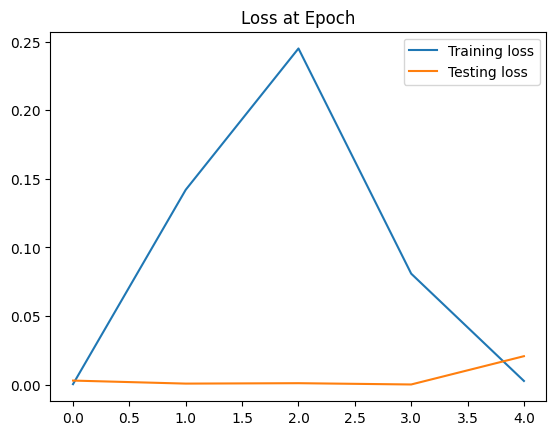

In [34]:
train_losses= [tl.item() for tl in train_losses]

plt.plot(train_losses,label="Training loss")
plt.plot(test_losses,label="Testing loss")
plt.title("Loss at Epoch")
plt.legend()

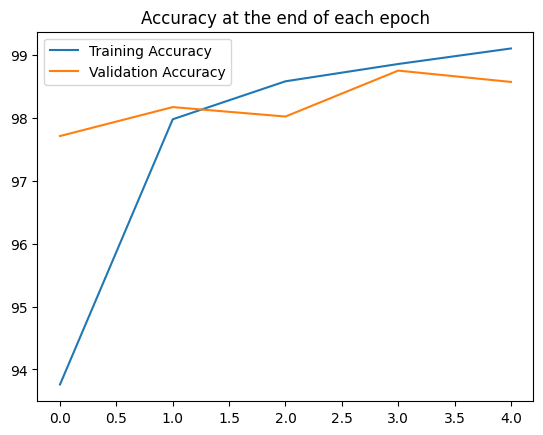

In [35]:
#graph the accuracy at the end of each epoch

plt.plot([t/600 for t in train_correct],label="Training Accuracy")
plt.plot([t/100 for t in test_correct],label="Validation Accuracy")
plt.title("Accuracy at the end of each epoch")
plt.legend()

In [37]:
test_load_everything=DataLoader(test_data,batch_size=10000,shuffle=False)

In [38]:
with torch.no_grad():
  correct=0
  for X_test,y_test in test_load_everything:
    y_val=model(X_test)
    predicted=torch.max(y_val,1)[1]
    correct+=(predicted==y_test).sum()

In [39]:
correct.item()/len(test_data)

0.9857

## Testing with an image

In [40]:
test_data[4140]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

Here in the last line we can see the tag that  the number is 8. We'll remove that and then pass it to the model

In [43]:
test_data[4140][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

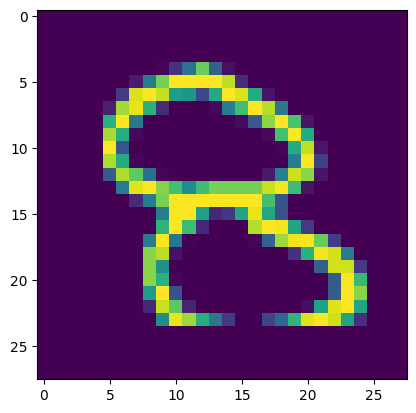

In [44]:
plt.imshow(test_data[4140][0].reshape(28,28))

In [45]:
## passing the image to the model
model.eval()
with torch.no_grad():
  new_predict=model(test_data[4140][0].view(1,1,28,28))

In [46]:
new_predict

tensor([[-2.0798e+01, -1.5206e+01, -5.2370e+00, -1.2109e+01, -2.3700e+01,
         -1.8746e+01, -1.7305e+01, -1.7422e+01, -5.3363e-03, -2.1040e+01]])

In [47]:
new_predict.argmax()

tensor(8)

The model gave highest weight to the 8th element within the tensor, the output 8 is same as the actual tag

## lets try with another test data

In [48]:
test_data[2000]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.1922, 0.6235, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0471,
           0.4863, 0.4431, 0.3020, 0.0000, 

tensor([[-1.7098e+01, -1.7927e+01, -2.2424e+01, -1.9848e+01, -2.0097e+01,
         -1.4672e+01, -5.9605e-07, -3.1725e+01, -1.5947e+01, -2.4104e+01]])
tensor(6)


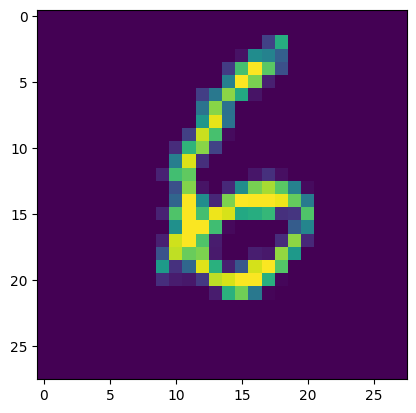

In [49]:
test_data[2000][0].reshape(28,28)
plt.imshow(test_data[2000][0].reshape(28,28))

## passing the image to the model
model.eval()
with torch.no_grad():
  new_predict=model(test_data[2000][0].view(1,1,28,28))

print(new_predict)
print(new_predict.argmax())

Even in the above case, model correctly predicted the number